<a href="https://colab.research.google.com/github/R0bk/ml_replications/blob/main/06_vqvae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Score Model

In [ ]:
!pip install torchinfo

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: robk (use `wandb login --relogin` to force relogin)


In [ ]:
!cat /usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py -n | sed '221,255!d'

   221	    def _publish(self, record: pb.Record, local: bool = None) -> None:
   222	        if self._process_check and self._process and not self._process.is_alive():
   223	            raise Exception("The wandb backend process has shutdown")
   224	        if local:
   225	            record.control.local = local
   226	        if self.record_q:
   227	            self.record_q.put(record)
   228	
   229	    def _communicate(
   230	        self, rec: pb.Record, timeout: Optional[int] = 5, local: bool = None
   231	    ) -> Optional[pb.Result]:
   232	        return self._communicate_async(rec, local=local).get(timeout=timeout)
   233	
   234	    def _communicate_async(self, rec: pb.Record, local: bool = None) -> MessageFuture:
   235	        assert self._router
   236	        if self._process_check and self._process and not self._process.is_alive():
   237	            raise Exception("The wandb backend process has shutdown")
   238	        future = self._router.send_and_receive(rec

In [ ]:
!sed -i '222,223 s/^/#/' /usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py

In [ ]:
!cat /usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py -n | sed '221,230!d'

   221	    def _publish(self, record: pb.Record, local: bool = None) -> None:
   222	#        if self._process_check and self._process and not self._process.is_alive():
   223	#            raise Exception("The wandb backend process has shutdown")
   224	        if local:
   225	            record.control.local = local
   226	        if self.record_q:
   227	            self.record_q.put(record)
   228	
   229	    def _communicate(
   230	        self, rec: pb.Record, timeout: Optional[int] = 5, local: bool = None


In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Resize, Normalize, CenterCrop
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary as tsummary
from torchvision.utils import make_grid
import functools

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
os.environ['XLA_USE_BF16']="1"
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
# device = xm.xla_device() # "cuda" if torch.cuda.is_available() else "cpu"
# print("Using {} device".format(device))

In [ ]:
import wandb
# !wandb login --relogin
!wandb sync --clean
os.environ['WANDB_START_METHOD'] = 'thread'
os.environ['WANDB_CONSOLE'] = 'off'
# wandb.init(project="score_model", entity="robk")

No runs older than 24 hours found


In [ ]:
import shutil
!mkdir /content/data
!mkdir /content/data/celeba
shutil.copy("/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip", "/content/data/celeba/img_align_celeba.zip")

In [ ]:
!unzip /content/data/celeba/img_align_celeba.zip -d /content/data/celeba/

In [ ]:
image_size = 128
training_data = datasets.ImageFolder(
    root='/content/data/celeba',
    transform=Compose([
        Resize(image_size),
        CenterCrop(image_size),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [ ]:
norm_mean = (0.5,0.5,0.5)
norm_std = (0.5,0.5,0.5)
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unnorm = UnNormalize(norm_mean, norm_std)

In [ ]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True

)
test_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 128, 128])
Shape of y:  torch.Size([128]) torch.int64


In [ ]:
def marginal_prob_std(t, sigma):
  t = torch.tensor(t, device=t.device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=t.device)

sigma = 25.
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[3, 64, 128, 256, 512, 1024], embed_dim=256):
        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim))

        self.enc_conv = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=2, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, stride=[1,2][i>0], bias=False),
                nn.ReLU(inplace=True),
            ) for i, (in_ch, out_ch) in enumerate(zip(channels[:-1], channels[1:]))
        ])
        self.enc_dense = nn.ModuleList([nn.Linear(embed_dim, in_ch) for in_ch in channels[1:]])
        self.enc_gnorm = nn.ModuleList([nn.GroupNorm([4, 64][i>0], num_channels=in_ch) for i, in_ch in enumerate(channels[1:])])

        self.dec_conv = nn.ModuleList([
            nn.ConvTranspose2d(
                [in_ch, in_ch*2][i>0],
                out_ch, 3,
                stride=[2,1][i==len(channels)-2],
                padding=1,
                output_padding=[1,1,0][(i>0) + (i==len(channels)-2)],
                bias=False
            ) for i, (in_ch, out_ch) in enumerate(zip(channels[::-1][:-1], channels[::-1][1:]))
        ])
        self.dec_dense = nn.ModuleList([nn.Linear(embed_dim, out_ch) for out_ch in channels[::-1][1:]])
        self.dec_gnorm = nn.ModuleList([nn.GroupNorm(64, num_channels=in_ch) for in_ch in channels[::-1][1:]])

        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        # print(x.shape)
        embed = self.act(self.embed(t))

        hs = []
        for conv, dense, norm in zip(self.enc_conv, self.enc_dense, self.enc_gnorm):
            x = conv(x)
            x = x + dense(embed)[..., None, None]
            x = self.act(norm(x))
            hs.insert(0, x)

        # for h in hs:
        #   print(f'h shape {h.shape}')
        for i, (conv, dense, norm, h) in enumerate(zip(self.dec_conv, self.dec_dense, self.dec_gnorm, hs), 1):
            # print(i)
            # print(f'x shape {x.shape}')
            # print(f'h shape {h.shape}')
            x = torch.cat([x, h], dim=1) if i != 1 else x
            x = conv(x)
            if i == len(self.dec_conv):
              continue
            x = x + dense(embed)[..., None, None]
            x = self.act(norm(x))
        # print(x.shape)
        return x / self.marginal_prob_std(t)[:, None, None, None]

model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to('cpu')
print(model)
# print(data_variance)

# tsummary(model, [(128, 3, 128, 128), (128,)], batch_dim=None, device='cpu')

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (enc_conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
def loss_fn(model, x, marginal_prod_std, batch_no, index, run, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  # print(random_t.shape)
  # print(x.shape)
  std = marginal_prod_std(random_t)
  z = torch.randn_like(x)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  # (s*std+z)**2 = 0
  # s = -z/std
  run.log({
      'index': index,
      'loss': loss
  })
  if batch_no %100 == 0:
      cleaned_x = perturbed_x + score
      grid_img = make_grid(torch.cat([x, perturbed_x, cleaned_x]), nrow=9)
      images = wandb.Image(grid_img)
      run.log({
          "examples": images,
          "timestep": random_t
      })
  return loss

In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import tqdm

ck_path = '/content/drive/MyDrive/celeb_ckpt.pth'

n_epochs = 10
## size of a mini-batch
batch_size = 128
## learning rate
lr = 1e-4


In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import tqdm

ck_path = '/content/drive/MyDrive/celeb_ckpt.pth'
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)

n_epochs = 10
## size of a mini-batch
batch_size = 128
## learning rate
lr = 1e-4

# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
batch_no = 0
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in train_dataloader:
    batch_no+=1
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn, batch_no)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  wandb.log({
      'epoch': epoch,
      'avg_loss': avg_loss / num_items,
      'num_items': num_items
  })
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), ck_path)

In [ ]:
xm.xrt_world_size()

1

In [ ]:
xm.get_xla_supported_devices()

['xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7', 'xla:8']

In [ ]:
run = wandb.init(project="score_model", entity="robk")

wandb: Currently logged in as: robk (use `wandb login --relogin` to force relogin)


In [ ]:
def _mp_fn(index):
    print('hi')
    run = wandb.init(project="score_model", entity="robk", group="SS2")
    print('made wandb', index)
    torch.manual_seed(0)
    device = xm.xla_device()
    mp_device_loader = pl.MpDeviceLoader(train_dataloader, device)
    print('making model', index)
    score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
    print('made model', index)
    optimizer = Adam(score_model.parameters(), lr=lr)
    batch_no = 0
    print('running bach', index)
    for x, _ in mp_device_loader:
        batch_no += 1
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn, batch_no, index, run)
        optimizer.zero_grad()
        loss.backward()    
        # avg_loss += loss.item() * x.shape[0]
        # num_items += x.shape[0]
        xm.optimizer_step(optimizer)
    xm.rendezvous('exit')


if __name__ == '__main__':
    xmp.spawn(_mp_fn, args=(), nprocs=8, start_method='fork')

hi
hi
hi
hi
hi
hi
hi
hi


Exception in device=TPU:7: 
Exception in device=TPU:6: 
Exception in device=TPU:4: 
Exception in device=TPU:2: 
Exception in device=TPU:1: 
Exception in device=TPU:3: 
Exception in device=TPU:5: 
Exception in device=TPU:0: 
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 914, in init
    wi.setup(kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 914, in init
    wi.setup(kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 914, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 914, in init
    wi.setup(kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 914, 

KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.7/dist-packages/wandb/jupyter.py", line 195, in notebook_metadata
    ipynb = attempt_colab_load_ipynb()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_setup.py", line 121, in _settings_setup
    s._infer_settings_from_env()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_setup.py", line 121, in _settings_setup
    s._infer_settings_from_env()
  File "/usr/local/lib/python3.7/dist-packages/wandb/jupyter.py", line 195, in notebook_metadata
    ipynb = attempt_colab_load_ipynb()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_settings.py", line 970, in _infer_settings_from_env
    meta = wandb.jupyter.notebook_metadata(self._silent)
  File "/usr/local/lib/python3.7/dist-packages/wandb/jupyter.py", line 195, in notebook_metadata
    ipynb = attempt_colab_load_ipynb()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_settings.py", line 970, in _infer_settings_from_env
    meta = wandb.jupyter.notebook

In [ ]:
RuntimeError                              Traceback (most recent call last)
<ipython-input-43-28caa1bc433d> in <module>()
     22 
     23 if __name__ == '__main__':
---> 24     xmp.spawn(_mp_fn, args=(), nprocs=1)

5 frames
/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py in mark_step()
    716   torch_xla._XLAC._xla_step_marker(
    717       torch_xla._XLAC._xla_get_default_device(), [],
--> 718       wait=xu.getenv_as('XLA_SYNC_WAIT', bool, False))
    719   # Only emit metrics from the first local device index, to avoid emitting the
    720   # same values from different threads.

RuntimeError: Resource exhausted: From /job:tpu_worker/replica:0/task:0:
2 root error(s) found.
  (0) Resource exhausted: Failed to allocate request for 256.00MiB (268435456B) on device ordinal 0
	 [[{{node XRTExecute}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[XRTExecute_G15]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted: Failed to allocate request for 256.00MiB (268435456B) on device ordinal 0
	 [[{{node XRTExecute}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored.

In [ ]:
# score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
# score_model = score_model.to(device)

n_epochs = 1
## size of a mini-batch
batch_size = 32
## learning rate
lr = 1e-4
with torch.no_grad():
  tqdm_epoch = tqdm.notebook.trange(n_epochs)
  batch_no = 0
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
      batch_no+=1
      x = x.to(device)    
      loss = loss_fn(score_model, x, marginal_prob_std_fn, batch_no)
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 128, 128, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:
## Load the pre-trained checkpoint from disk.
ckpt = torch.load(ck_path, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, n_embed, embed_dim, decay=0.99, eps=1e-5, beta=0.25):
        super(VectorQuantizerEMA, self).__init__()
        self.n_embed = n_embed
        self.embed_dim = embed_dim
        self.decay = decay
        self.eps = eps
        self.commitment_cost = beta

        self.register_buffer('embeddings', torch.rand(embed_dim, n_embed))
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', self.embeddings.clone())

    def forward(self, x):
        # convert inputs from N*X_1*X_2...X_n -> -1*EmbedDim
        x = x.permute(0, 2, 3, 1).contiguous()
        flat_inputs = x.view(-1, self.embed_dim)

        distances = (
            flat_inputs.pow(2).sum(1, keepdims=True) -
            2 * flat_inputs.mm(self.embeddings) +
            self.embeddings.pow(2).sum(0, keepdims=True))

        encoding_indices = torch.argmin(distances, 1)
        encoding = F.one_hot(encoding_indices, self.n_embed)

        encoding_indices = encoding_indices.view(x.shape[:-1])
        quantized = self.embeddings.t().index_select(0, encoding_indices.view(-1)).view(x.shape)

        latent_loss = F.mse_loss(quantized.detach(), x)
        commitment_loss = latent_loss * self.commitment_cost

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(1 - self.decay, encoding.sum(0))
            
            n = self.cluster_size.data.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )

            # Goal here is to calculate the average of the inputs w.r.t each encoding
            embed_sum = flat_inputs.t() @ encoding.type_as(x)
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            self.embeddings.data = self.embed_avg / cluster_size.unsqueeze(0)

        # pass through grad to encoder
        quantized = x + quantized.detach() - x.detach()

        avg_probs = encoding.type_as(flat_inputs).mean(0)
        perplexity = (-(avg_probs * avg_probs.add(1e-10).log()).sum()).exp()
        return quantized.permute(0, 3, 1, 2), commitment_loss, perplexity


class VectorQuantizerEMAStack(nn.Module):
    def __init__(self, in_channels, n_embed, embed_dim, **attrs):
        super(VectorQuantizerEMAStack, self).__init__()
        self.conv = nn.Conv2d(in_channels, embed_dim, 1)
        self.vq = VectorQuantizerEMA(n_embed, embed_dim, **attrs)

    def forward(self, x):
        return self.vq(self.conv(x))


In [ ]:
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hidden, num_residual_layers, num_residual_hidden):
        super(ResidualStack, self).__init__()
        self.in_channels = in_channels
        self.num_hidden = num_hidden
        self.num_residual_layers = num_residual_layers
        self.num_residual_hidden = num_residual_hidden

        self.layers = nn.ModuleList([nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, num_residual_hidden, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_residual_hidden, num_hidden, 1, stride=1)
        ) for i in range(self.num_residual_layers)])

    def forward(self, h):
        for res in self.layers:
            h = h + res(h)
        return F.relu(h)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, n_hidden, n_residual_layers, n_residual_hidden, layer_level=0):
        super(Encoder, self).__init__()
        self.n_hidden = n_hidden
        self.n_residual_layers = n_residual_layers
        self.n_residual_hidden = n_residual_hidden
        self.layer_level = layer_level

        layers = [
            nn.Conv2d(in_channels, n_hidden//2, 4, stride=2, padding=1),
            nn.ReLU(True)
        ]
        last_chan_size = n_hidden//2
        for i in range(layer_level):
            layers.extend([
                nn.Conv2d(last_chan_size, n_hidden, 4, stride=2, padding=1),
                nn.ReLU(True)
            ])
            last_chan_size = n_hidden
        layers.extend([
            nn.Conv2d(last_chan_size, n_hidden, 3, padding=1),
            ResidualStack(n_hidden, n_hidden, n_residual_layers, n_residual_hidden)
        ])

        self.encoder = nn.Sequential(*layers)


    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, n_hidden, n_residual_layers, n_residual_hidden, layer_level=0):
        super(Decoder, self).__init__()
        self.n_hidden = n_hidden
        self.n_residual_layers = n_residual_layers
        self.n_residual_hidden = n_residual_hidden

        layers = [
            nn.Conv2d(in_channels, n_hidden, 3, padding=1),
            ResidualStack(n_hidden, n_hidden, n_residual_layers, n_residual_hidden)
        ]
        last_chan_size = n_hidden
        for i in range(layer_level):
            layers.extend([
                nn.ConvTranspose2d(last_chan_size, last_chan_size//2, 4, stride=2, padding=1),
                nn.ReLU(True)
            ])
            last_chan_size = last_chan_size//2
        layers.append(
            nn.ConvTranspose2d(last_chan_size, out_channels, 4, stride=2, padding=1)
        )

        self.decoder = nn.Sequential(*layers)


    def forward(self, x):
        return self.decoder(x)


class VQVAE(nn.Module):
    def __init__(
        self,
        input_channels=3,
        embed_size=512,
        embed_dim=64,
        n_hidden=128,
        n_residual_layers=2,
        n_residual_hidden=32,
        layers=2,
        data_variance=1.
    ):
        super(VQVAE, self).__init__()
        self.input_channels = input_channels
        self.embed_size = embed_size
        self.embed_dim = embed_dim
        self.n_hidden = n_hidden
        self.n_residual_layers = n_residual_layers
        self.n_residual_hidden = n_residual_hidden
        self.layers = layers

        self._data_variance = data_variance

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.vqs = nn.ModuleList()
        
        for i in range(layers):
            self.encoders.append(Encoder(
                [n_hidden, input_channels][i],
                n_hidden,
                n_residual_layers,
                n_residual_hidden,
                layer_level=i
            ))
            self.decoders.append(Decoder(
                [embed_dim, embed_dim+embed_dim][i],
                [embed_dim, input_channels][i],
                n_hidden,
                n_residual_layers,
                n_residual_hidden,
                layer_level=i
            ))
            self.vqs.append(VectorQuantizerEMAStack(
                [n_hidden, n_hidden+embed_dim][i],
                embed_size, embed_dim
            ))

        self.upsample = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)


    def forward(self, x):
        encodings = [x] # [n(x), ..., enc(enc(x)), enc(x), x]
        for enc in self.encoders[::-1]:
            encodings.insert(0, enc(encodings[0]))
        

        qs = []
        cats = [encodings[0]]
        ups = []
        commitment_loss = torch.zeros(self.layers)
        perplexities = torch.zeros(self.layers)

        for i in range(self.layers):
            q, coml, perp = self.vqs[i](cats[i])
            commitment_loss[i] = coml
            perplexities[i] = perp
  
            if self.layers-1 != i:
                # print(self.decoders[i])
                # print(self.decoders[i](q).shape)
                # print(self.encoders[::-1][i+1])
                # print(encodings[i+1].shape)
                cats.append(torch.cat([self.decoders[i](q), encodings[i+1]], 1))

            for _ in range(self.layers-i-1):
                # print('upscaling q')
                # print(q.shape)
                q = self.upsample(q)
                # print(q.shape)
                # print('done upscaling')
            qs.append(q)

        # print('qs')
        # for q in qs:
        #   print(q.shape)
        qs = torch.cat(qs, 1)
        dec = self.decoders[-1](qs)
        recon_loss = F.mse_loss(x, dec) / data_variance
        return dec, recon_loss, commitment_loss, perplexities


model = VQVAE(data_variance=data_variance).to(device)
print(model)
print(data_variance)

summary(model, (3, 128, 128))

VQVAE(
  (encoders): ModuleList(
    (0): Encoder(
      (encoder): Sequential(
        (0): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ResidualStack(
          (layers): ModuleList(
            (0): Sequential(
              (0): ReLU()
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU()
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
            )
            (1): Sequential(
              (0): ReLU()
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU()
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
      )
    )
    (1): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     

(tensor(1388867), tensor(1388867))

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        # print(n, p)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [ ]:
def train(dataloader, model, optimiser):
  size = len(train_dataloader.dataset)

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred, recon_loss, com_loss, perplexities = model(X)
    loss = recon_loss + com_loss.mean()

    optimiser.zero_grad()
    loss.backward()
    # plot_grad_flow(model.named_parameters())
    optimiser.step()

    if batch % 25 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} recon_loss: {recon_loss:>5f} com_loss: {com_loss.tolist()} perplexity: {perplexities.tolist()} [{current:>5d}/{size:>5d}]")
    # break

In [ ]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimiser)
print("Done!")

Epoch 1
-------------------------------
loss: 1.069459 recon_loss: 1.068122 com_loss: [0.002221079543232918, 0.0004528819117695093] perplexity: [1.0, 1.0] [    0/202599]
loss: 0.499567 recon_loss: 0.375474 com_loss: [0.003328639082610607, 0.24485576152801514] perplexity: [1.0, 1.9865949153900146] [ 3200/202599]
loss: 0.626556 recon_loss: 0.405300 com_loss: [0.038692407310009, 0.403820276260376] perplexity: [1.0, 1.8260700702667236] [ 6400/202599]
loss: 0.790831 recon_loss: 0.350836 com_loss: [0.3590819537639618, 0.5209088921546936] perplexity: [1.0, 1.9970166683197021] [ 9600/202599]
loss: 1.651187 recon_loss: 0.551619 com_loss: [0.9511617422103882, 1.2479742765426636] perplexity: [1.0, 1.8161460161209106] [12800/202599]
loss: 0.987525 recon_loss: 0.938918 com_loss: [0.007377604953944683, 0.08983621746301651] perplexity: [1.0, 1.0] [16000/202599]
loss: 0.503301 recon_loss: 0.378937 com_loss: [0.004114460200071335, 0.24461369216442108] perplexity: [1.0, 1.9137319326400757] [19200/202599

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

def plot(dataloader, model, plot_count=30):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    imgs = []
    with torch.no_grad():
        data_iter = iter(dataloader)
        for i in range(plot_count):
            X, y = next(data_iter)
            
            X, y = X.to(device), y.to(device)
            pred, recon_loss, com_loss, perplexities = model(X)
            imgs.append(unnorm(X.cpu()[0]))
            imgs.append(unnorm(pred.cpu()[0]))
    return imgs

grid_img = make_grid(plot(test_dataloader, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


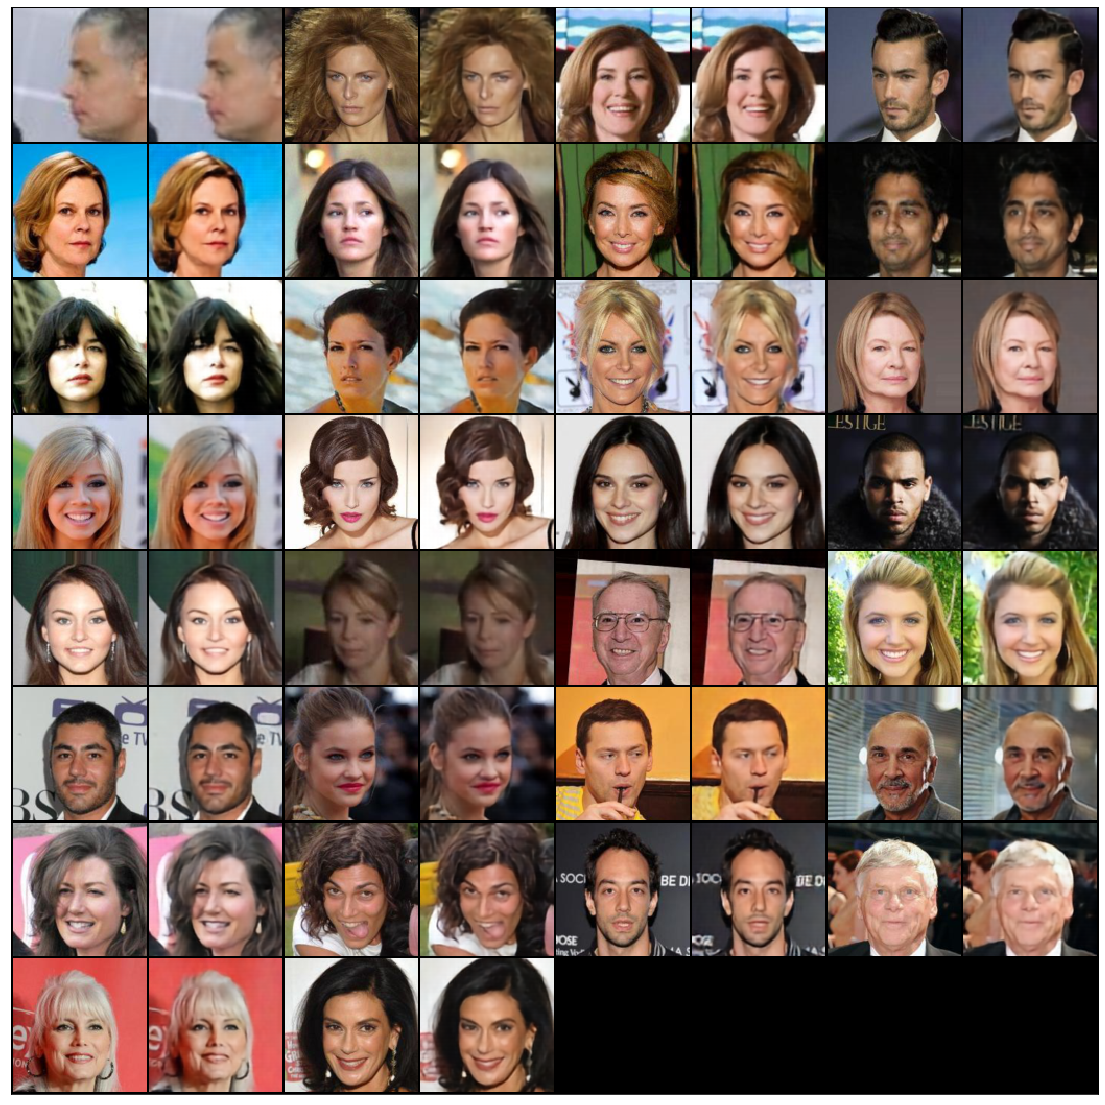

In [ ]:
plt.figure(figsize = (20, 20))
show(grid_img)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
|!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward0>)


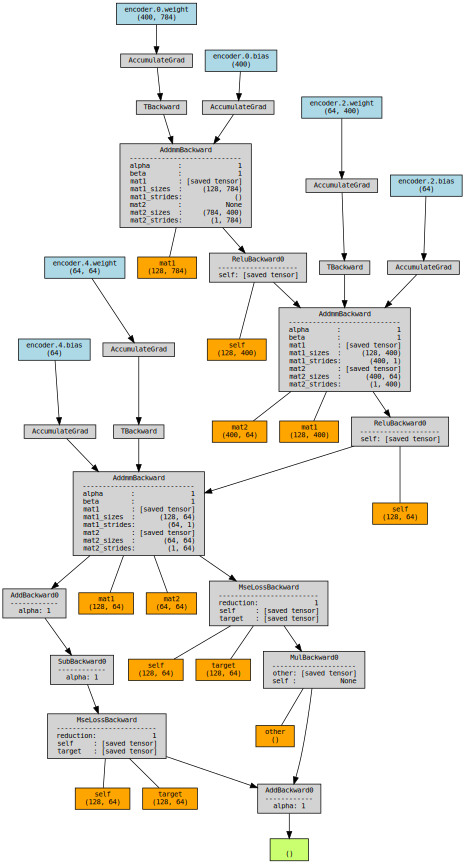

In [ ]:
from torchviz import make_dot, make_dot_from_trace
model.eval()
# with torch.no_grad():
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    x, pred, loss = model(X)
    print(pred)
    break
make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

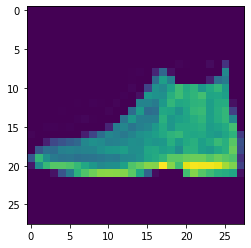

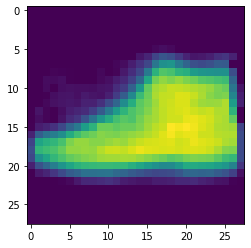

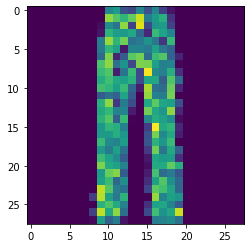

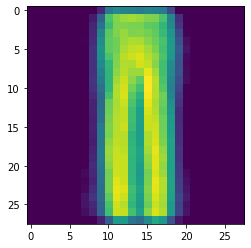

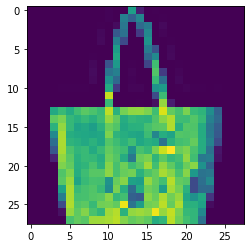

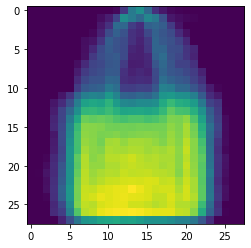

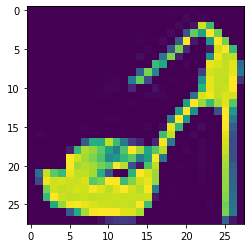

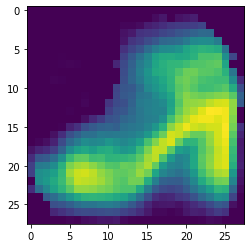

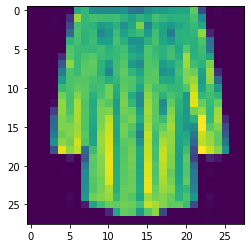

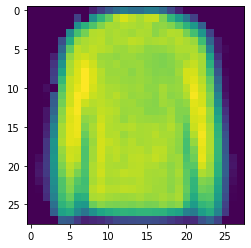

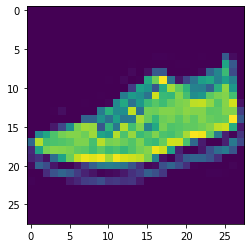

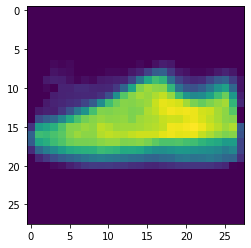

In [ ]:
def plot(dataloader, model):
    i = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            i += 1
            print(X)
            X, y = X.to(device), y.to(device)
            pred, loss = model(X)
            print(pred)
            plt.figure()
            plt.imshow(  X.cpu()[0].squeeze()  )
            plt.figure()
            plt.imshow(  pred.cpu().unflatten(1, torch.Size([28, 28]))[0]  )
            if i > 5:
              break
plot(test_dataloader, model)

## Refrences for implementation for for checking correctness

#### Papers
https://arxiv.org/pdf/1906.00446.pdf

https://arxiv.org/abs/1711.00937

#### Discussions
https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

#### Implementations
https://github.com/rosinality/vq-vae-2-pytorch

https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py

https://colab.research.google.com/gist/tomhennigan/62edee62a4638e0d0ab9738a757043ed/tf2_vq_vae_training_example.ipynb#scrollTo=cIRl2ZtxoKNz

https://github.com/nadavbh12/VQ-VAE/blob/master/main.py

https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=-uqLy_taUUbI

https://github.com/MishaLaskin/vqvae